# Project Deliverable 1: Initial Report and Analysis
### Ishan Ranjan, U77038717

### Preliminary Data Collection and Pre-Processing

To collect data, the API for the usaspending.gov website was used. Namely the endpoints ```/search/spending_by_category/naics/``` and ```/search/spending_by_award/``` were utilized. Data on specific awards above $50,000 were gathered from the USAspending.gov website search tool, and can be found in the files ```Contracts_PrimeAwardSummaries_2023-11-17_H07M46S22_1.csv``` and ```Contracts_PrimeAwardSummaries_2023-11-17_H16M15S15_1.csv```. 

### Two Questions and Preliminary Analysis

To analyze the above data, we must first formulate two questions that we can explore with the data. The questions that we can explore are:
1. For industries related to Engineering, Software Development and Consulting, how has the spending changed, and who were the top firms?
2. Which recipients have recieved the highest amount of awards for the past two fiscal years?


#### Analysis of Industry Codes

To analyze total spending for the industry codes 541512 (Computer systems design services), 541330 (Engineering Services), and 541690 (Other scientific and technical consulting services) we can get use functions below:

In [12]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



def get_spending_data(start_date, end_date, naics_code):
    
    '''
    Function to get spending data given a year range and NAICS code.

    Takes in a start date, end date, and NAICS code.
    '''
    
    # Define the API endpoint URL
    base_url = "https://api.usaspending.gov/api/v2/search/spending_by_category/naics/"

    url = f"{base_url}{naics_code}"

    agency_object = {
        "type": "awarding",  
        "tier": "toptier",   
        "name": "Department of Defense"  
    }
    
    # Construct the payload
    payload = {
        "filters": {
            "time_period": [
                {
                    "start_date": start_date,
                    "end_date": end_date
                }
            ],
            "naics_codes": {
                "require": [naics_code]
            },
            "agencies": [agency_object]
        },
        "category": "naics",
        "limit": 5,
        "page": 1
    }

    # Make the API request
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return None
    
def annual_spending_range(start_year, end_year, naics_code):

    '''
    Wrapper function for get_spending_data() to get annual spending data for a range of years.
    '''

    annual_spending = {}

    for year in range(start_year, end_year):
        start_date = f"{year}-01-01"
        end_date = f"{year + 1}-01-01"  

        result = get_spending_data(start_date, end_date, naics_code)
        
        if result and 'results' in result and len(result['results']) > 0:
            annual_spending[year] = result['results'][0]['amount']
        else:
            annual_spending[year] = 0

    return annual_spending

def plot_annual_spending(start_year, end_year, naics_code):

    '''
    Function to plot annual spending given a year range and NAICS code.
    '''
    
    data = annual_spending_range(start_year, end_year, naics_code)

    years = list(data.keys())
    amounts = list(data.values())
    df = pd.DataFrame({'Year': years, 'Amount': amounts})

    sns.set(style="whitegrid")
    plt.figure(figsize=(17, 6))
    ax = sns.barplot(x="Year", y="Amount", hue="Amount", data=df, palette="Blues_d")

    plt.xlabel('Year')
    plt.ylabel('Amount')
    title = f'NAICS Code {naics_code} Spending Over the Years'
    plt.title(title)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

    ax.get_legend().remove()

    plt.show()

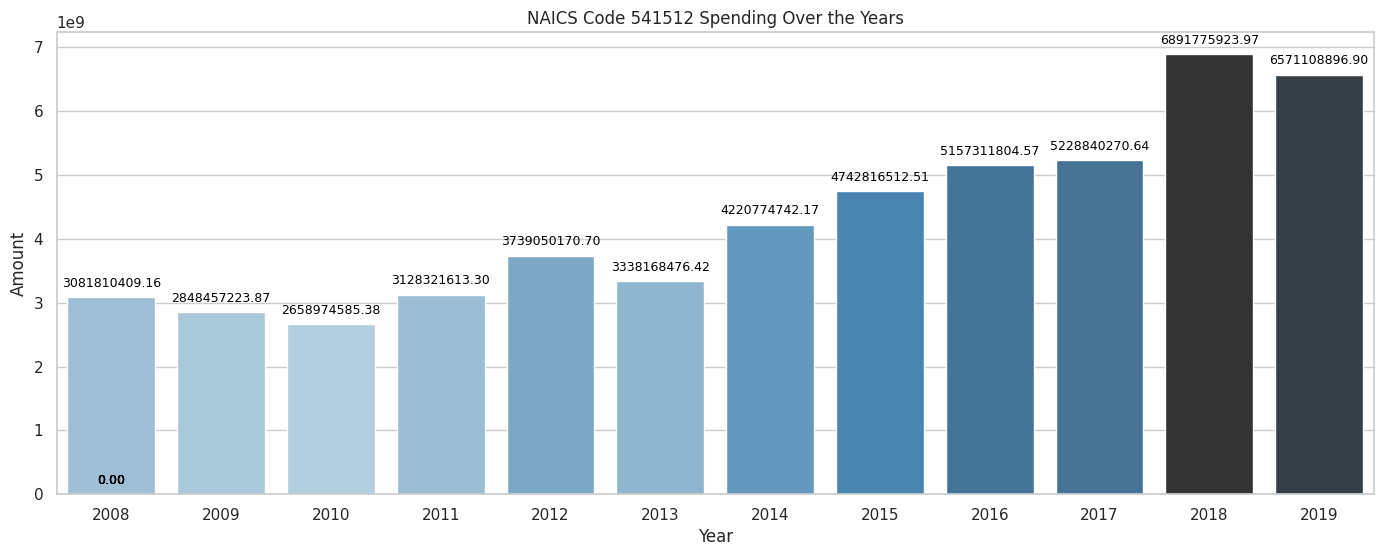

In [13]:
# Plot annual spending for code 541512, Computer Systems Design Services
plot_annual_spending(2008, 2020, "541512")

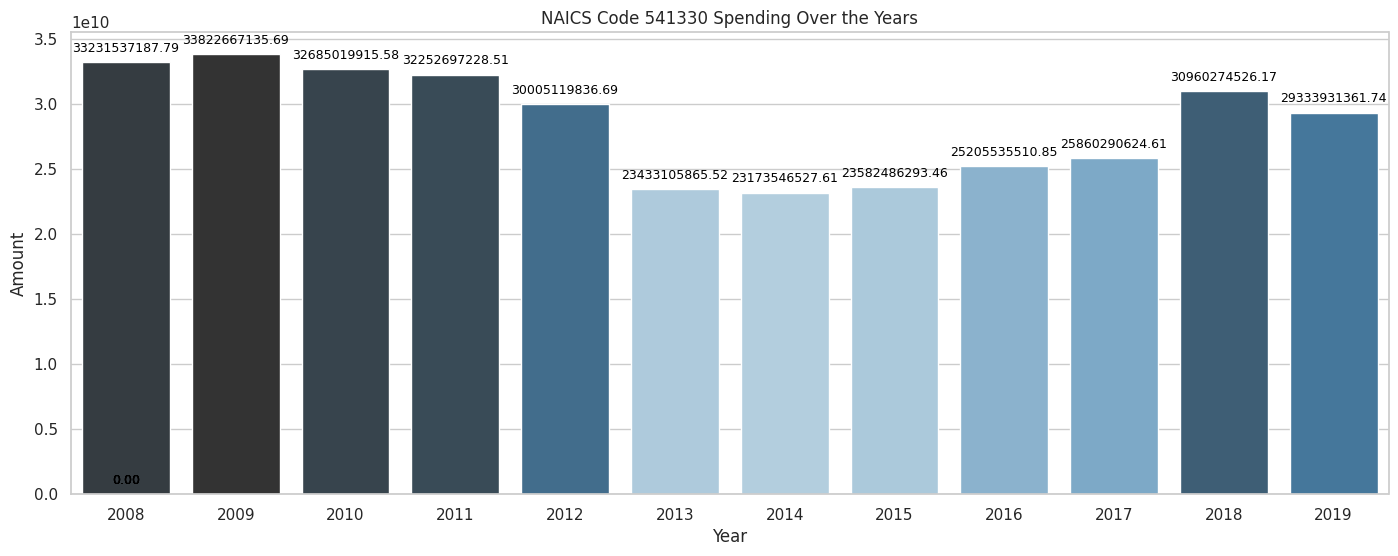

In [14]:
# Plot annual spending for code 541330, Engineering Services
plot_annual_spending(2008, 2020, "541330")

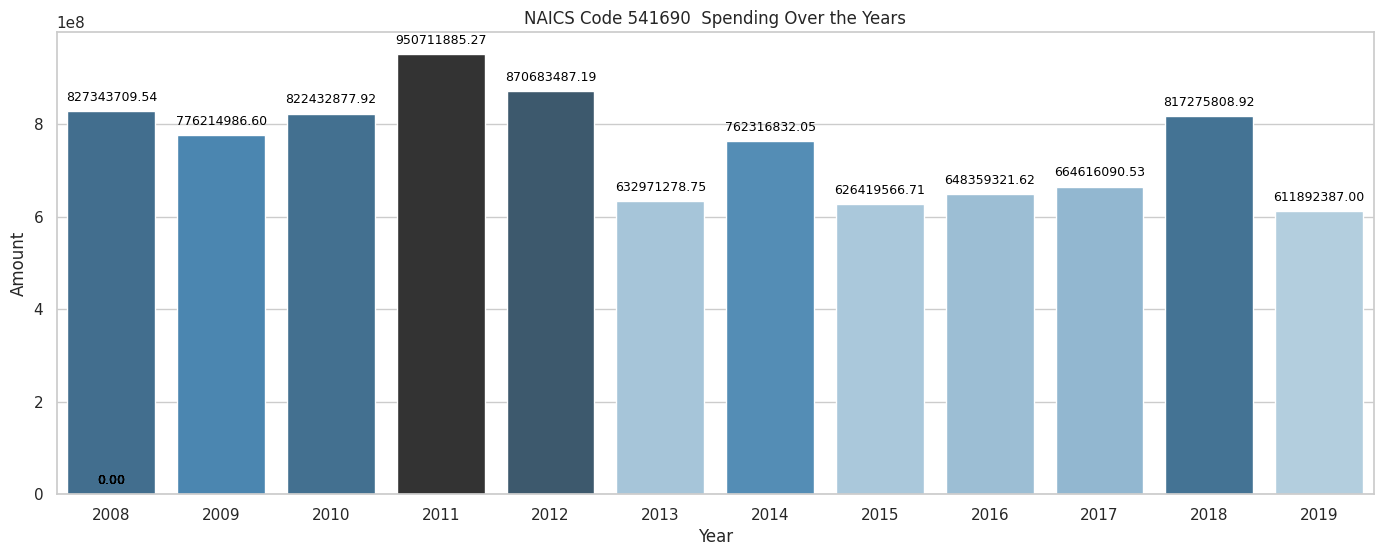

In [15]:
# Plot annual spending for code 541690, Other Scientific and Technical Consulting Services
plot_annual_spending(2008, 2020, "541690 ")

To analyze the highest contract awarded each year for each code, we can use the code below:

In [17]:
import requests

def fetch_highest_contract(year, naics_code):
    url = 'https://api.usaspending.gov/api/v2/search/spending_by_award/'
    
    agency_object = {
        "type": "awarding",  
        "tier": "toptier",   
        "name": "Department of Defense"  
    }
    
    params = {
        "filters": {
            "time_period": [{"start_date": f"{year}-10-01", "end_date": f"{year+1}-09-30"}],
            "naics_codes": [naics_code],
            "agencies": [agency_object],
            "award_type_codes": ["C"]
        },
        "fields": ["Award Amount", "Recipient Name"],
        "limit": 100,  # Adjust this value based on the total number of awards
        "page": 1,
        "order": "desc",
        "sort": "Award Amount"
    }
    response = requests.post(url, json=params)
    response.raise_for_status()
    result = response.json()
    if result['results']:
        highest_contract = result['results'][0]
        return highest_contract
    else:
        return None

def get_highest_contracts(naics_code):
    years = range(2008, 2023)  # Adjust the year range as needed
    highest_contracts = {}
    for year in years:
        highest_contract = fetch_highest_contract(year, naics_code)
        if highest_contract:
            highest_contracts[year] = highest_contract
    return highest_contracts

def plot_largest_contracts(contracts_dict, naics_code):
    years = list(contracts_dict.keys())
    highest_contracts = [float(item['Award Amount']) for item in contracts_dict.values()]
    df = pd.DataFrame({'Year': years, 'Highest Contract Value': highest_contracts})

    sns.set(style="whitegrid")
    plt.figure(figsize=(17, 6))
    ax = sns.barplot(x="Year", y="Highest Contract Value", hue="Highest Contract Value", data=df, palette="Blues_d")

    plt.xlabel('Year')
    plt.ylabel('Highest Contract Value')
    title = f'NAICS Code {naics_code} Highest Contract Values'
    plt.title(title)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

    ax.get_legend().remove()

    plt.show()

Now we can get the highest contracts for each year:

In [18]:
highest_contracts_541512 = get_highest_contracts("541512")
highest_contracts_541330 = get_highest_contracts("541330")
highest_contracts_541690 = get_highest_contracts("541690")

In [19]:
print("Highest Contracts for NAICS Code 541512, Computer Systems and Design Services")
for year, contract in highest_contracts_541512.items():
    print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")

Highest Contracts for NAICS Code 541512, Computer Systems and Design Services
Year 2008: Highest Contract Value - $343868897.15, Company - ACCENTURE LLP
Year 2009: Highest Contract Value - $343868897.15, Company - ACCENTURE LLP
Year 2010: Highest Contract Value - $675858853.69, Company - ACCENTURE LLP
Year 2011: Highest Contract Value - $675858853.69, Company - ACCENTURE LLP
Year 2012: Highest Contract Value - $675858853.69, Company - ACCENTURE LLP
Year 2013: Highest Contract Value - $675858853.69, Company - ACCENTURE LLP
Year 2014: Highest Contract Value - $675858853.69, Company - ACCENTURE LLP
Year 2015: Highest Contract Value - $675858853.69, Company - ACCENTURE LLP
Year 2016: Highest Contract Value - $969903635.37, Company - JACOBS TECHNOLOGY INC.
Year 2017: Highest Contract Value - $969903635.37, Company - JACOBS TECHNOLOGY INC.
Year 2018: Highest Contract Value - $969903635.37, Company - JACOBS TECHNOLOGY INC.
Year 2019: Highest Contract Value - $969903635.37, Company - JACOBS TE

In [20]:
print("Highest Contracts for NAICS Code 541330, Engineering Services")
for year, contract in highest_contracts_541330.items():
    print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")

Highest Contracts for NAICS Code 541330, Engineering Services
Year 2008: Highest Contract Value - $721120996.53, Company - BAE SYSTEMS TECHNOLOGY SOLUTIONS & SERVICES INC.
Year 2009: Highest Contract Value - $721120996.53, Company - BAE SYSTEMS TECHNOLOGY SOLUTIONS & SERVICES INC.
Year 2010: Highest Contract Value - $721120996.53, Company - BAE SYSTEMS TECHNOLOGY SOLUTIONS & SERVICES INC.
Year 2011: Highest Contract Value - $721120996.53, Company - BAE SYSTEMS TECHNOLOGY SOLUTIONS & SERVICES INC.
Year 2012: Highest Contract Value - $721120996.53, Company - BAE SYSTEMS TECHNOLOGY SOLUTIONS & SERVICES INC.
Year 2013: Highest Contract Value - $721120996.53, Company - BAE SYSTEMS TECHNOLOGY SOLUTIONS & SERVICES INC.
Year 2014: Highest Contract Value - $721120996.53, Company - BAE SYSTEMS TECHNOLOGY SOLUTIONS & SERVICES INC.
Year 2015: Highest Contract Value - $721120996.53, Company - BAE SYSTEMS TECHNOLOGY SOLUTIONS & SERVICES INC.
Year 2016: Highest Contract Value - $721120996.53, Company

In [21]:
print("Highest Contracts for NAICS Code 541690, Other scientific and technical consulting services")
for year, contract in highest_contracts_541690.items():
    print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")

Highest Contracts for NAICS Code 541690, Other scientific and technical consulting services
Year 2008: Highest Contract Value - $94944179.61, Company - AMERESCO SELECT, INC.
Year 2009: Highest Contract Value - $94944179.61, Company - AMERESCO SELECT, INC.
Year 2010: Highest Contract Value - $94944179.61, Company - AMERESCO SELECT, INC.
Year 2011: Highest Contract Value - $94944179.61, Company - AMERESCO SELECT, INC.
Year 2012: Highest Contract Value - $94944179.61, Company - AMERESCO SELECT, INC.
Year 2013: Highest Contract Value - $94944179.61, Company - AMERESCO SELECT, INC.
Year 2014: Highest Contract Value - $94944179.61, Company - AMERESCO SELECT, INC.
Year 2015: Highest Contract Value - $94944179.61, Company - AMERESCO SELECT, INC.
Year 2016: Highest Contract Value - $108284628.2, Company - JOHNS HOPKINS UNIVERSITY APPLIED PHYSICS LABORATORY LLC, THE
Year 2017: Highest Contract Value - $108284628.2, Company - JOHNS HOPKINS UNIVERSITY APPLIED PHYSICS LABORATORY LLC, THE
Year 2018:

We can also plot the highest value contract for each year

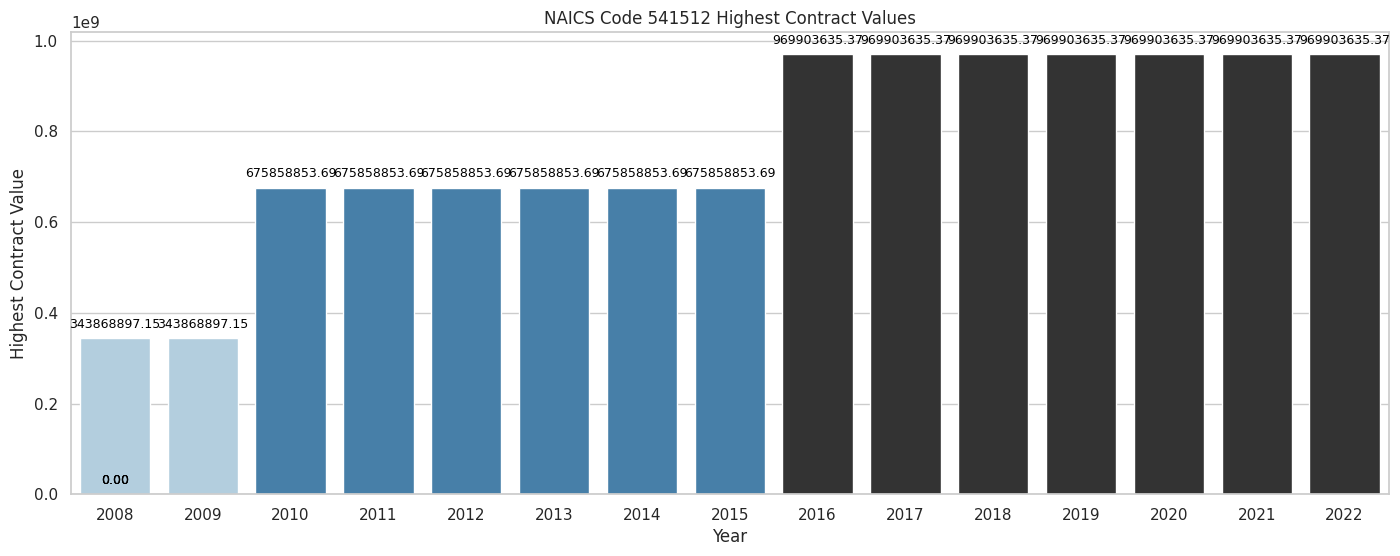

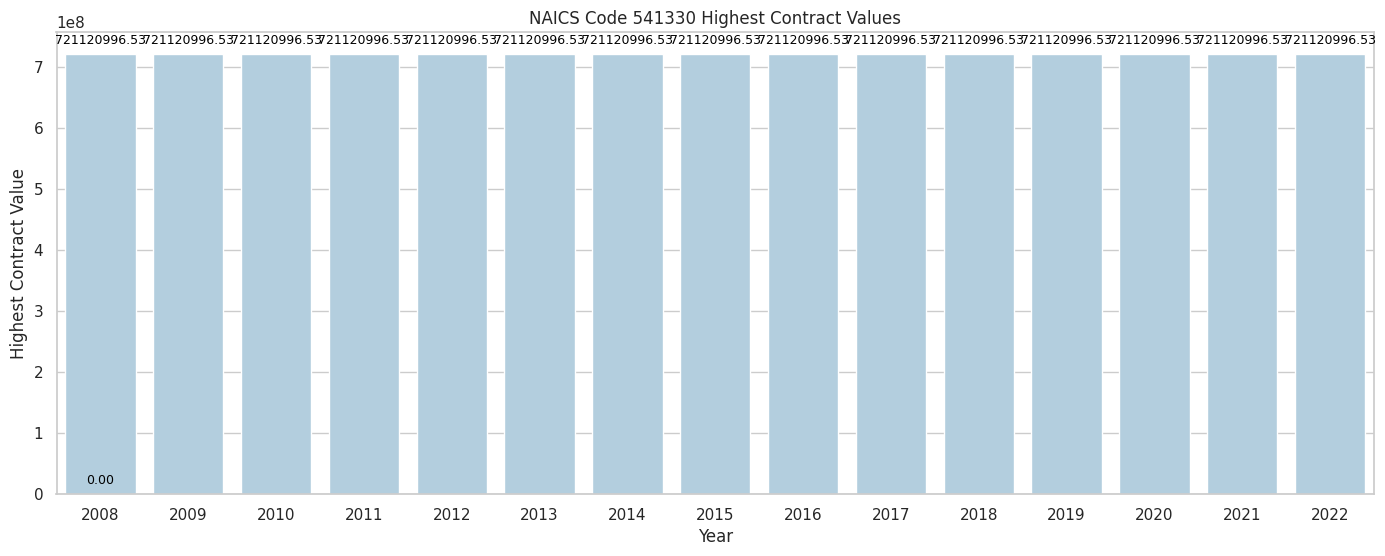

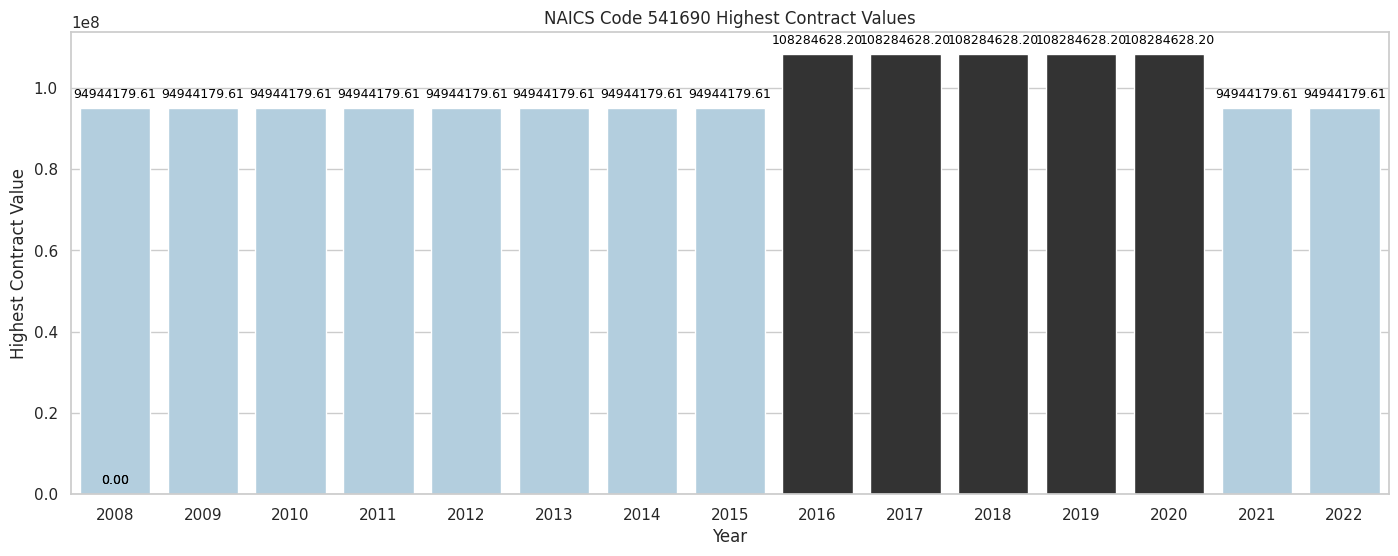

In [22]:
plot_largest_contracts(highest_contracts_541512, "541512")
plot_largest_contracts(highest_contracts_541330, "541330")
plot_largest_contracts(highest_contracts_541690, "541690")

Now that our first question has been answered, we can take a look at our second question: Which vendors secured the most contracts in the last 2 fiscal years?

We can take a look at the total award data for contracts above a value of $50,000 in the last 2 fiscal years from the 2 CSVs that were downloaded from USASpending.

In [23]:
data_2021 = pd.read_csv("Contracts_PrimeAwardSummaries_2023-11-17_H07M46S22_1.csv")
data_2022 = pd.read_csv("Contracts_PrimeAwardSummaries_2023-11-17_H16M15S15_1.csv")

/tmp/ipykernel_2380263/919734746.py:1: DtypeWarning: Columns (22,42,66,67,76,87,156) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2021 = pd.read_csv("Contracts_PrimeAwardSummaries_2023-11-17_H07M46S22_1.csv")
/tmp/ipykernel_2380263/919734746.py:2: DtypeWarning: Columns (42,66,67,76,156) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2022 = pd.read_csv("Contracts_PrimeAwardSummaries_2023-11-17_H16M15S15_1.csv")


In [24]:
data_2021.head()

,contract_award_unique_key,award_id_piid,parent_award_agency_id,parent_award_agency_name,parent_award_id_piid,disaster_emergency_fund_codes,outlayed_amount_from_COVID-19_supplementals,obligated_amount_from_COVID-19_supplementals,outlayed_amount_from_IIJA_supplemental,obligated_amount_from_IIJA_supplemental,...,highly_compensated_officer_2_name,highly_compensated_officer_2_amount,highly_compensated_officer_3_name,highly_compensated_officer_3_amount,highly_compensated_officer_4_name,highly_compensated_officer_4_amount,highly_compensated_officer_5_name,highly_compensated_officer_5_amount,usaspending_permalink,last_modified_date
0,CONT_AWD_N4008419F4080_9700_N4008414D5702_9700,N4008419F4080,9700.0,DEPT OF DEFENSE,N4008414D5702,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_N40...,2023-09-28
1,CONT_AWD_W9123821F0076_9700_W912DQ21D4009_9700,W9123821F0076,9700.0,DEPT OF DEFENSE,W912DQ21D4009,Q: Excluded from tracking (uses non-emergency/...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_W91...,2023-08-25
2,CONT_AWD_FA568221F0014018_9700_FA568221A0014_9700,FA568221F0014018,9700.0,DEPT OF DEFENSE,FA568221A0014,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_FA5...,2023-11-13
3,CONT_AWD_FA480021F0177_9700_FA800320D0023_9700,FA480021F0177,9700.0,DEPT OF DEFENSE,FA800320D0023,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_FA4...,2022-05-31
4,CONT_AWD_N0060421F8014_9700_N0060420A4000_9700,N0060421F8014,9700.0,DEPT OF DEFENSE,N0060420A4000,NaN,NaN,NaN,NaN,NaN,...,THOMAS HOUSE,442067.0,NEIL SIDEBOTHAM,388937.0,VINCENT L GRIFFITH,361346.0,ROBERT LEDENKO,360871.0,https://www.usaspending.gov/award/CONT_AWD_N00...,2023-10-29


In [25]:
data_2022.head()

,contract_award_unique_key,award_id_piid,parent_award_agency_id,parent_award_agency_name,parent_award_id_piid,disaster_emergency_fund_codes,outlayed_amount_from_COVID-19_supplementals,obligated_amount_from_COVID-19_supplementals,outlayed_amount_from_IIJA_supplemental,obligated_amount_from_IIJA_supplemental,...,highly_compensated_officer_2_name,highly_compensated_officer_2_amount,highly_compensated_officer_3_name,highly_compensated_officer_3_amount,highly_compensated_officer_4_name,highly_compensated_officer_4_amount,highly_compensated_officer_5_name,highly_compensated_officer_5_amount,usaspending_permalink,last_modified_date
0,CONT_AWD_W50S6L22F0008_9700_W50S6L22D0001_9700,W50S6L22F0008,9700.0,DEPT OF DEFENSE,W50S6L22D0001,Q: Excluded from tracking (uses non-emergency/...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_W50...,2023-11-01
1,CONT_AWD_SPRTA122F2750_9700_SPE4A122G0015_9700,SPRTA122F2750,9700.0,DEPT OF DEFENSE,SPE4A122G0015,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_SPR...,2023-01-27
2,CONT_AWD_SPRBL122F0189_9700_FA857620D0001_9700,SPRBL122F0189,9700.0,DEPT OF DEFENSE,FA857620D0001,Q: Excluded from tracking (uses non-emergency/...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_SPR...,2023-01-31
3,CONT_AWD_SPE60522FQQ5E_9700_SPE60518D1256_9700,SPE60522FQQ5E,9700.0,DEPT OF DEFENSE,SPE60518D1256,Q: Excluded from tracking (uses non-emergency/...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_SPE...,2022-12-27
4,CONT_AWD_SPE2DX22F86GH_9700_SPE2DX15D2205_9700,SPE2DX22F86GH,9700.0,DEPT OF DEFENSE,SPE2DX15D2205,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.usaspending.gov/award/CONT_AWD_SPE...,2022-10-01


In [28]:
recipients_2021 = data_2021['recipient_name']
recipients_2021

0                          AMERICAN ENGINEERING CORPORATION
1               BURNS & MCDONNELL ENGINEERING COMPANY, INC.
2                                    AVIROMS RENT-A-CAR SRL
3                                               DA NOLT INC
4                             NOBLE SUPPLY & LOGISTICS, LLC
                                ...                        
301533                                         AVARINT, LLC
301534                                 MACAULAY-BROWN, INC.
301535                                   THE BOEING COMPANY
301536    RUGGED INFORMATION TECHNOLOGY EQUIPMENT CORPOR...
301537                 NORTHROP GRUMMAN SYSTEMS CORPORATION
Name: recipient_name, Length: 301538, dtype: object

In [29]:
recipients_2022 = data_2022['recipient_name']
recipients_2022

0                                     A2M CONSULTING LLC
1                            HONEYWELL INTERNATIONAL INC
2                           HONEYWELL INTERNATIONAL INC.
3                 UNITED CAPITAL INVESTMENTS GROUP, INC.
4                            AMERISOURCEBERGEN DRUG CORP
                               ...                      
288079                        ERICKSON HELICOPTERS, INC.
288080    SCIENCE APPLICATIONS INTERNATIONAL CORPORATION
288081                                THE BOEING COMPANY
288082                                THE BOEING COMPANY
288083                                           UES INC
Name: recipient_name, Length: 288084, dtype: object

In [30]:
recipients_2021.value_counts()


MCKESSON CORPORATION                    9174
AMERISOURCEBERGEN DRUG CORP             5431
ATLANTIC DIVING SUPPLY, INC.            3964
LOCKHEED MARTIN CORPORATION             3459
NORTHROP GRUMMAN SYSTEMS CORPORATION    3422
                                        ... 
ABEL UNLIMITED INC.                        1
AIXTRON, INC.                              1
URS-SMITHGROUP JOINT VENTURE               1
WALGA MTE LLC                              1
SOFTWARE TECHNOLOGY INC                    1
Name: recipient_name, Length: 32749, dtype: int64

In [31]:
recipients_2022.value_counts()

MCKESSON CORPORATION                    8461
AMERISOURCEBERGEN DRUG CORP             5006
ATLANTIC DIVING SUPPLY, INC.            4269
LOCKHEED MARTIN CORPORATION             3169
NORTHROP GRUMMAN SYSTEMS CORPORATION    3028
                                        ... 
LIBERTY RAILWAY SERVICES, INC.             1
OCT CONSULTING LLC                         1
COMCO, INC.                                1
SIRIUS COMPUTER SOLUTIONS, LLC             1
NTT DATA FEDHEALTH, INC.                   1
Name: recipient_name, Length: 31242, dtype: int64

As we can see, the top 5 contract-securing vendors for both 2021 and 2022 were as follows:
1. McKesson Corporation
2. Amerisourcebergen Drug Corp.
3. Atlantic Diving Supply Inc.
4. Lockheed Martin Corporation
5. Northrop Grumman Systems Corproation

### Refined project scope and list of limitations

With the above findings, I think we can narrow the project scope to performing a very initial analysis that gives a good overview of Department of Defense Spending. Finding top vendors and contract values should be more important than specific contract details. Also, creating a database of contract awards and details should be a high priority for us. 

#### Data and potential risks of achieving project goal
Potential risks of achieving the project goal mainly center around the fact that we are using the USASpending API for all of our data. We have no idea if this API is monitored, or if the US Government has any idea of what we want to do with this data. As students we have no competing interests, but we don't know about the data security given such analysis has not been done before.